## E9. 네이버 영화리뷰 감성분석 도전하기

### 1)데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


In [3]:
print('테스트용 리뷰 개수 :',len(test_data)) 

테스트용 리뷰 개수 : 50000


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 2)데이터로더 구성

In [5]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [6]:
def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    #데이터의 중복제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    #NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    # 한국어 토크나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    #사전 word_to_index 구성
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    #X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
  
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
print(len(train_data))

146183


In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포 확인

In [10]:
len(max(X_train, key=len))

116

In [11]:
len(max(X_test, key=len))

105

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.969355837799927


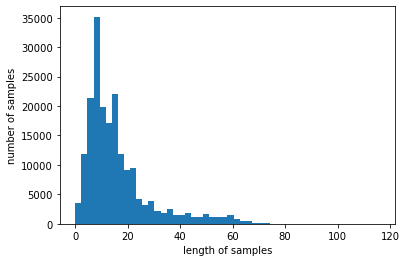

In [17]:
total_data_text=list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('리뷰의 최대 길이 :',max(len(l) for l in total_data_text))
print('리뷰의 평균 길이 :',sum(map(len, total_data_text))/len(total_data_text))
plt.hist([len(s) for s in total_data_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [19]:
max_len = 60
below_threshold_len(max_len, total_data_text)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 98.82255975509243


- 적절한 최대 문장 길이를 60으로 지정

- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [20]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=60)

In [21]:
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=60)

### 4) 모델구성 및 validation set 구성

In [24]:
# Model 1
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 어휘 사전의 크기입니다(10개의 단어)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


In [22]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

# validation set 10000건 분리
#x_val = np.asarray(X_train[:100000]) 
#y_val = np.asarray(y_train[:100000])

# validation set을 제외한 나머지
#partial_x_train = np.asarray(X_train[10000:])
#partial_y_train = np.asarray(y_train[10000:])

#partial_x_train[:5], partial_y_train[:5]

### 5) 모델 훈련 개시

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 36s 135ms/step - loss: 0.4271 - accuracy: 0.8007 - val_loss: 0.3351 - val_accuracy: 0.8514
Epoch 2/20
266/266 [==============================] - 36s 137ms/step - loss: 0.3182 - accuracy: 0.8644 - val_loss: 0.3319 - val_accuracy: 0.8538
Epoch 3/20
266/266 [==============================] - 37s 140ms/step - loss: 0.2850 - accuracy: 0.8800 - val_loss: 0.3196 - val_accuracy: 0.8650
Epoch 4/20
266/266 [==============================] - 40s 151ms/step - loss: 0.2574 - accuracy: 0.8925 - val_loss: 0.3292 - val_accuracy: 0.8588
Epoch 5/20
266/266 [==============================] - 38s 144ms/step - loss: 0.2327 - accuracy: 0.9047 - val_loss: 0.3266 - val_accuracy: 0.8580
Epoch 6/20
266/266 [==============================] - 36s 137ms/step - loss: 0.2116 - accuracy: 0.9149 - val_loss: 0.3550 - val_accuracy: 0.8592
Epoch 7/20
266/266 [==============================] - 36s 134ms/step - loss: 0.1926 - accuracy: 0.9230 - val_loss: 0.3807 - val_ac

In [26]:
model_results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 12s - loss: 0.8445 - accuracy: 0.8410


- 모델 2가지 더 구성 및 훈련

In [27]:
#model2. globalmaxpooling 1d

model = keras.Sequential(name="GlobalMaxPooling1D")

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "GlobalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 13ms/step - loss: 0.5005 - accuracy: 0.7732 - val_loss: 0.3574 - val_accuracy: 0.8473
Epoch 2/20
266/266 [==============================] - 4s 13ms/step - loss: 0.3246 - accuracy: 0.8649 - val_loss: 0.3290 - val_accuracy: 0.8524
Epoch 3/20
266/266 [==============================] - 4s 13ms/step - loss: 0.2792 - accuracy: 0.8869 - val_loss: 0.3312 - val_accuracy: 0.8548
Epoch 4/20
266/266 [==============================] - 4s 14ms/step - loss: 0.2447 - accuracy: 0.9037 - val_loss: 0.3387 - val_accuracy: 0.8549
Epoch 5/20
266/266 [==============================] - 4s 13ms/step - loss: 0.2125 - accuracy: 0.9188 - val_loss: 0.3533 - val_accuracy: 0.8532
Epoch 6/20
266/266 [==============================] - 4s 14ms/step - loss: 0.1803 - accuracy: 0.9349 - val_loss: 0.3693 - val_accuracy: 0.8541
Epoch 7/20
266/266 [==============================] - 4s 13ms/step - loss: 0.1496 - accuracy: 0.9488 - val_loss: 0.3978 - val_accuracy: 0.8502

In [29]:
model_results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 1s - loss: 0.8059 - accuracy: 0.8282


In [59]:
#model3. cnn
model = keras.Sequential(name="CNN")
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9       

In [60]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 20s 76ms/step - loss: 0.5233 - accuracy: 0.7191 - val_loss: 0.4507 - val_accuracy: 0.7726
Epoch 2/20
266/266 [==============================] - 20s 76ms/step - loss: 0.4123 - accuracy: 0.7980 - val_loss: 0.4471 - val_accuracy: 0.7674
Epoch 3/20
266/266 [==============================] - 21s 78ms/step - loss: 0.3563 - accuracy: 0.8290 - val_loss: 0.4623 - val_accuracy: 0.7673
Epoch 4/20
266/266 [==============================] - 20s 76ms/step - loss: 0.2902 - accuracy: 0.8618 - val_loss: 0.5058 - val_accuracy: 0.7674
Epoch 5/20
266/266 [==============================] - 20s 76ms/step - loss: 0.2334 - accuracy: 0.8878 - val_loss: 0.5759 - val_accuracy: 0.7575
Epoch 6/20
266/266 [==============================] - 20s 76ms/step - loss: 0.1936 - accuracy: 0.9038 - val_loss: 0.6491 - val_accuracy: 0.7602
Epoch 7/20
266/266 [==============================] - 20s 77ms/step - loss: 0.1672 - accuracy: 0.9138 - val_loss: 0.7568 - val_accuracy:

In [61]:
model_results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 1s - loss: 1.5168 - accuracy: 0.7460


### 6) Loss, Accuracy 시각화

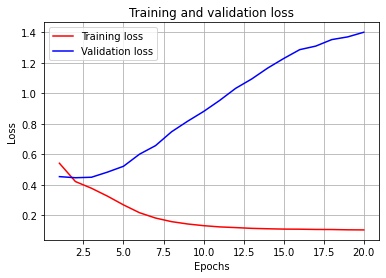

In [33]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

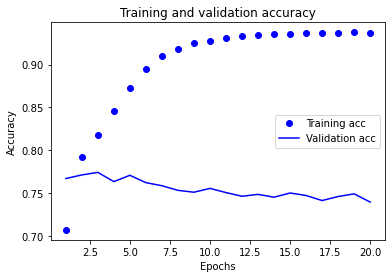

In [34]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 embedding 레이어 분석

In [35]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 100)


In [37]:
import os

word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']

word_vectors.similar_by_word('사랑')

[('장난아', 0.6445578336715698),
 ('즐겼', 0.6321127414703369),
 ('이색', 0.618808925151825),
 ('조상', 0.6124051213264465),
 ('오열', 0.609819769859314),
 ('예민', 0.5920579433441162),
 ('이루어질', 0.5782299637794495),
 ('사춘기', 0.5760762691497803),
 ('망설이', 0.5752516984939575),
 ('top', 0.5747371912002563)]

### 8) 한국어 word2vec 임베딩 활용하여 성능 개선

In [40]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'

In [41]:
from gensim.models import Word2Vec

word2vec = Word2Vec.load(word2vec_file_path)

In [58]:
result = word2vec.wv.most_similar("사랑")
print(result)

[('슬픔', 0.7216663360595703), ('행복', 0.6759077310562134), ('절망', 0.6468985676765442), ('기쁨', 0.6458414793014526), ('이별', 0.6334798336029053), ('추억', 0.6320937871932983), ('인생', 0.6216273307800293), ('애정', 0.6206068992614746), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]


- '사랑'과 훨씬 관련도가 높은 단어들이 출력 되었음

In [42]:
vocab_size = 10000    # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [54]:
from tensorflow.keras.initializers import Constant

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=max_len,
                                 trainable=True)) 
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 60, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy', 
             metrics=['accuracy'])

history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
1064/1064 [==============================] - 69s 65ms/step - loss: 0.3936 - accuracy: 0.8194 - val_loss: 0.3221 - val_accuracy: 0.8591
Epoch 2/20
1064/1064 [==============================] - 72s 67ms/step - loss: 0.2934 - accuracy: 0.8753 - val_loss: 0.3057 - val_accuracy: 0.8689
Epoch 3/20
1064/1064 [==============================] - 76s 71ms/step - loss: 0.2539 - accuracy: 0.8942 - val_loss: 0.3022 - val_accuracy: 0.8687
Epoch 4/20
1064/1064 [==============================] - 77s 72ms/step - loss: 0.2197 - accuracy: 0.9109 - val_loss: 0.3129 - val_accuracy: 0.8721
Epoch 5/20
1064/1064 [==============================] - 82s 77ms/step - loss: 0.1853 - accuracy: 0.9269 - val_loss: 0.3392 - val_accuracy: 0.8675
Epoch 6/20
1064/1064 [==============================] - 79s 74ms/step - loss: 0.1515 - accuracy: 0.9410 - val_loss: 0.3670 - val_accuracy: 0.8623
Epoch 7/20
1064/1064 [==============================] - 72s 68ms/step - loss: 0.1196 - accuracy: 0.9545 - val_loss: 0.4223 -

In [57]:
model_results = model.evaluate(X_test,  y_test, verbose=2)

print(model_results)

1537/1537 - 14s - loss: 1.0373 - accuracy: 0.8525
[1.0373166799545288, 0.8525133728981018]


- 정확도 85% 달성

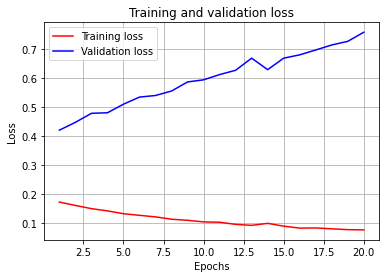

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

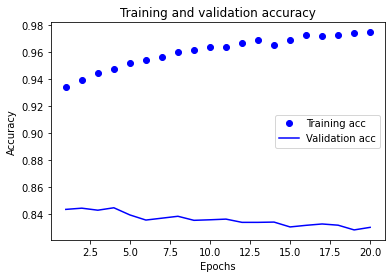

In [52]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 3가지 이상의 모델이 성공적으로 시도되었음
- gensim 유사 단어 찾기를 활용하여 자체학습한 임베딩과 사전 학습 임베딩을 적절히 분석함
- 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함